In [10]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas
from datasets.dataset import Dataset, AdvBehaviorsConfig

In [11]:
d = Dataset.from_name("adv_behaviors")(
    AdvBehaviorsConfig(
        "adv_behaviors",
        messages_path="/nfs/staff-ssd/beyer/llm-quick-check/data/behavior_datasets/harmbench_behaviors_text_all.csv",
        targets_path="/nfs/staff-ssd/beyer/llm-quick-check/data/optimizer_targets/harmbench_targets_text.json",
        seed=0,
        categories=[
            "chemical_biological",
            "illegal",
            "misinformation_disinformation",
            "harmful",
            "harassment_bullying",
            "cybercrime_intrusion",
        ],
    )
)


In [13]:
attack_runs = []
data_path = '../outputs'
for folder in os.listdir(data_path):
    # if folder in dates:
    for root, dirs, files in os.walk(os.path.join(data_path, folder)):
        for file in files:
            if file.endswith('run.json'):
                # print(os.path.join(root, file))
                data = pandas.read_json(os.path.join(root, file))
                for i in range(len(data)):
                    attack_runs.append(data.iloc[i])

In [4]:
prompts = []
for run in attack_runs:
    prompts.extend([p['content'] for p in run["prompts"]])
prompts = set(prompts)


# for each prompt, we will store all attacks that applied to it
indexed_attack_runs = {}

for run in attack_runs:
    config = run['config']
    model = config['model']
    model_params = config['model_params']
    attack = config['attack']
    attack_params = config['attack_params']
    dataset = config['dataset']
    prompts = run["prompts"]
    if 'successes_cais' not in run or isinstance(run['successes_cais'], float):
        print(f"WARNING: Skipping unjudged run: {run['config']['model'], run['config']['attack'], run['config']['dataset'], run['config']['dataset_params']['idx']}")
        continue

    for attack, loss, prompt, completion, success in zip(run['attacks'], run['losses'], run['prompts'], run['completions'], run['successes_cais']):
        if prompt['content'] not in indexed_attack_runs:
            indexed_attack_runs[prompt['content']] = []
        indexed_attack_runs[prompt['content']].append({
            'config': config,
            'model': model,
            'attack': attack,
            'dataset': dataset,
            'loss': loss,
            'completion': completion,
            'success': [s == 'Yes' for s in success]
        })
print(len(indexed_attack_runs))

319


# Find missing attacks

Did we attack `model` with `attack` across all prompts yet?

In [25]:
prompt_to_idx = {prompt[0]['content']: idx for idx, prompt in enumerate(d)}

tgt_model = 'HuggingFaceH4/zephyr-7b-beta'
tgt_attack = 'autodan'
idx = []
for prompt, runs in indexed_attack_runs.items():

    models_attacks = set((run['config']['model'], run['config']['attack']) for run in runs)
    if (tgt_model, tgt_attack) not in models_attacks:
        try:
            idx.append(prompt_to_idx[prompt])
        except KeyError:
            # prompt from jbb
            pass
if idx:
    template = "python run_attacks.py -m ++model_name={tgt_model} ++dataset_name=adv_behaviors ++datasets.adv_behaviors.idx={idx} ++attack_name={tgt_attack} ++hydra.launcher.timeout_min=240"
    idx = ','.join(map(str, sorted(idx)))
    print(template.format(tgt_model=tgt_model, idx=idx, tgt_attack=tgt_attack))

python run_attacks.py -m ++model_name=HuggingFaceH4/zephyr-7b-beta ++dataset_name=adv_behaviors ++datasets.adv_behaviors.idx=0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,2

## Visualize

In [6]:
from functools import lru_cache

@lru_cache
def get_color_for_run(model_type: str, attack_type: str):
    # Define a base color for each model (7 options)

    model_colors = {
        k: v
        for k, v in zip(
            set([run["config"]["model"] for run in attack_runs]),
            (
                (255, 0, 0),
                (255, 135, 0),
                (255, 211, 0),
                (222, 255, 10),
                (161, 255, 10),
                (10, 255, 153),
                (10, 239, 255),
                (20, 125, 245),
                (88, 10, 255),
                (190, 10, 255),
                (255, 10, 235),
                (255, 10, 60),
            ),
        )
    }

    # Define a variation for each attack type
    attack_variation = {
        "autodan": 0.4,  # Slightly darker
        "gcg": 1.0,  # Slightly darker
        "pgd": 0.7,  # Slightly lighter
        "pgd_one_hot": 0.85
    }

    # Get the base color for the model
    base_color = np.array(model_colors[model_type])

    # Adjust the color based on the attack type (by scaling the brightness)
    adjusted_color = np.clip(base_color * attack_variation[attack_type], 0, 255) / 255.0

    return adjusted_color


def ragged_mean(sequences):
    # Find the maximum length of the sequences
    max_len = max(len(seq) for seq in sequences)

    # Pad sequences with NaN to make them the same length
    padded_sequences = np.full((len(sequences), max_len), np.nan)

    for i, seq in enumerate(sequences):
        padded_sequences[i, : len(seq)] = seq

    # Compute the mean along axis 0, ignoring NaN values
    means = np.nanmean(padded_sequences, axis=0)

    return means


def filter_runs(runs, model_name=None, attack_type=None):
    filtered_runs = []
    for run in runs:
        if model_name is None:
            pass
        elif (
            isinstance(model_name, str) and model_name in run["config"]["model"].lower()
        ):
            pass
        elif isinstance(model_name, list) and any(
            m in run["config"]["model"].lower() for m in model_name
        ):
            pass
        else:
            continue
        if attack_type is None:
            pass
        elif (
            isinstance(attack_type, str)
            and attack_type == run["config"]["attack"].lower()
        ):
            pass
        elif isinstance(attack_type, list) and any(
            m == run["config"]["attack"].lower() for m in attack_type
        ):
            pass
        else:
            continue
        filtered_runs.append(run)
    return filtered_runs

In [7]:
def plot_prompts(prompts, metric='loss', model_name: None|str|list[str] = None, attack_type: None|str|list[str] = None):
    if not isinstance(prompts, list):
        prompts = [prompts]
    n = 0
    to_plot = {}
    for prompt in prompts:
        prompt_runs = filter_runs(indexed_attack_runs[prompt], model_name, attack_type)

        for run in prompt_runs:
            key = (run['config']['model'], run['config']['attack'])
            to_plot.setdefault(key, []).append(run[metric])

    plt.figure(figsize=(12, 6))
    for key, values in to_plot.items():
        model, attack = key
        plt.plot(ragged_mean(values), label=f"{model} | {attack}", c=get_color_for_run(model, attack))
        for value in values:
            plt.plot(value, alpha=min(0.1, (1.5/len(values))), c=get_color_for_run(model, attack))
            n += 1
    if metric == 'loss':
        plt.yscale('log')
    plt.title(f"{metric} for {n} runs across {len(prompts)} prompts, model={model_name if model_name is not None else "All"}, attack={attack_type}")
    plt.xlabel("Step")
    plt.legend()

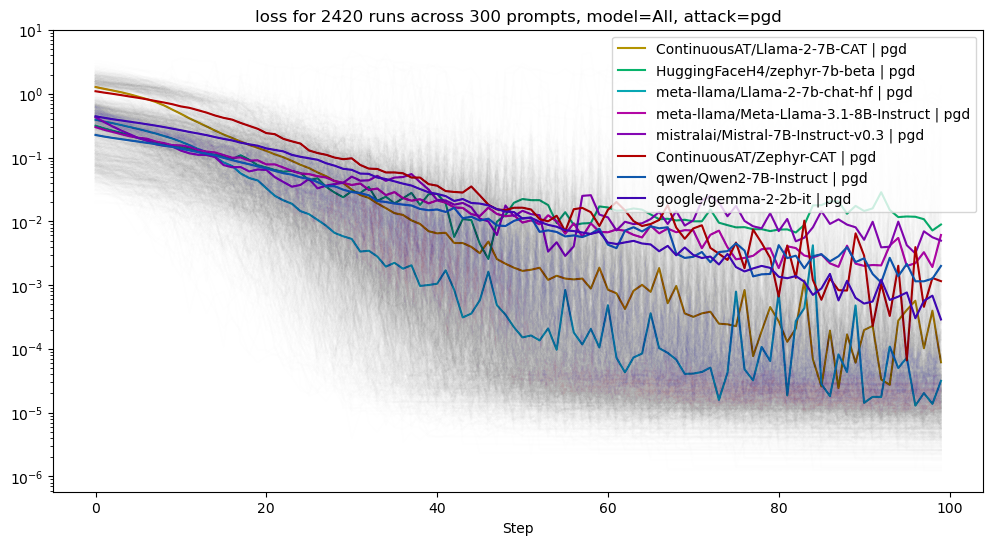

In [8]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name=None, attack_type='pgd')

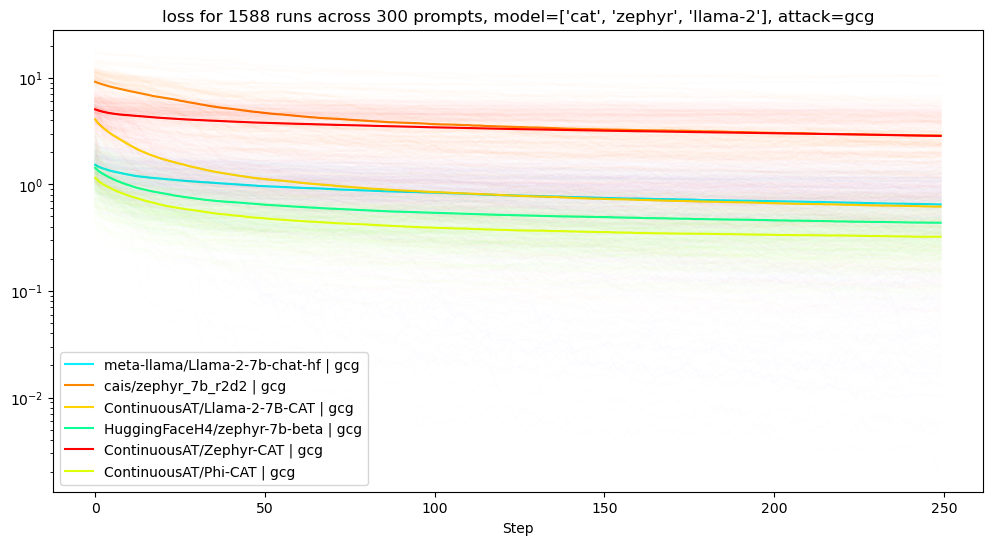

In [9]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name=['cat', 'zephyr', 'llama-2'], attack_type='gcg')

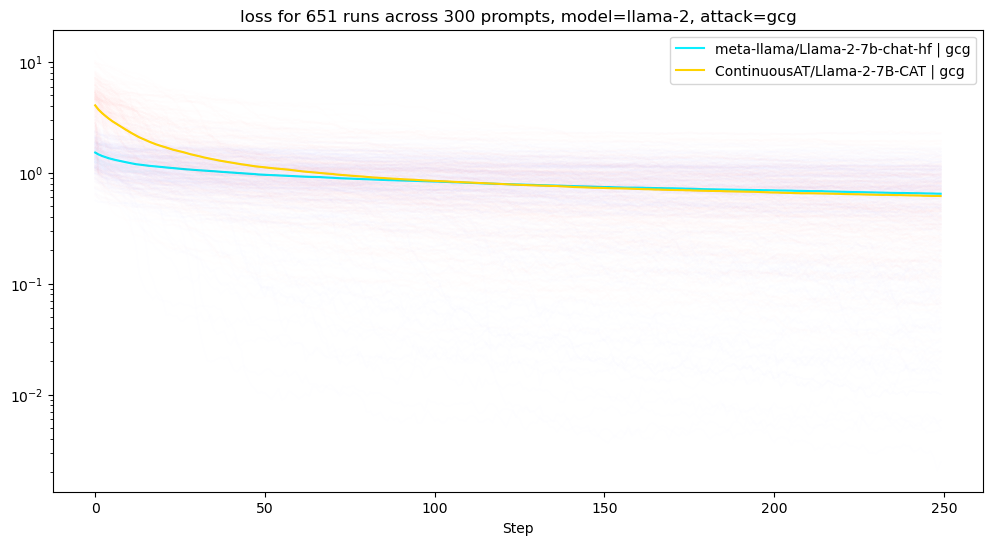

In [10]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name='llama-2', attack_type='gcg')

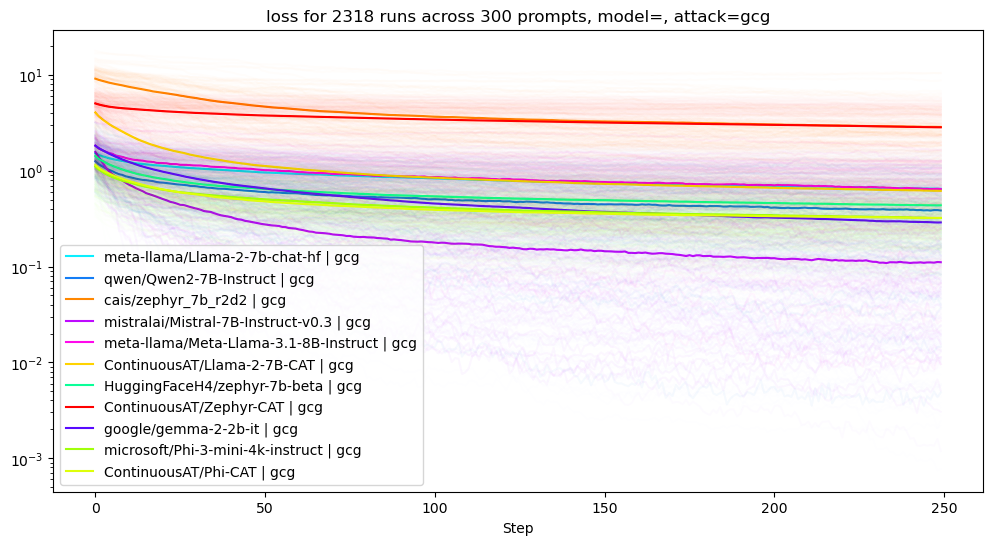

In [11]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name='', attack_type='gcg')

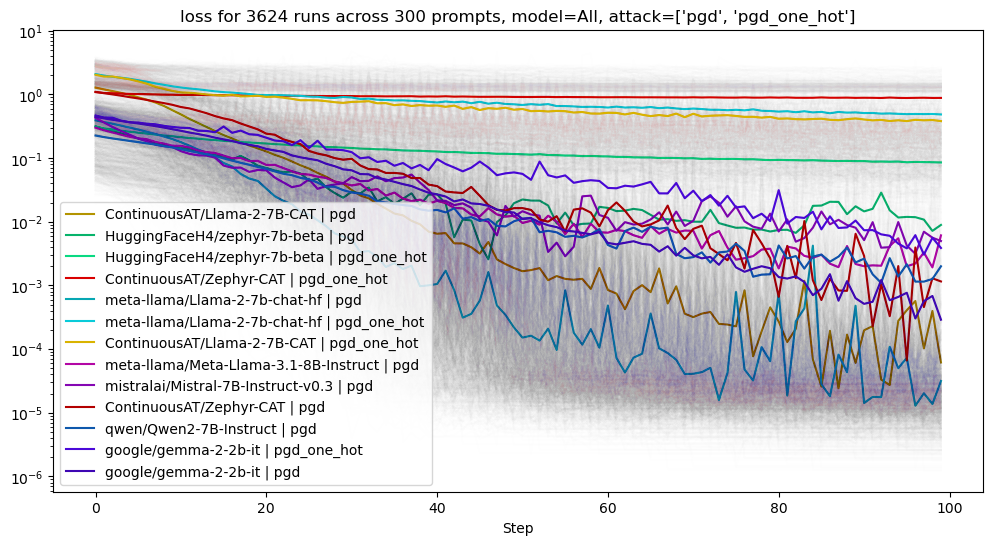

In [12]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name=None, attack_type=['pgd','pgd_one_hot'])

In [13]:
def plot_asr(prompts, model_name: None|str|list[str] = None, attack_type: None|str|list[str] = None):
    if not isinstance(prompts, list):
        prompts = [prompts]
    n = 0
    to_plot = {}
    for prompt in prompts:
        prompt_runs = filter_runs(indexed_attack_runs[prompt], model_name, attack_type)

        for run in prompt_runs:
            key = (run['config']['model'], run['config']['attack'])
            to_plot.setdefault(key, []).append(run['success'])


    plt.figure(figsize=(12, 6))
    y = []
    labels = []
    colors = []
    for key, values in to_plot.items():
        model, attack = key
        n += len(values)
        y.append(ragged_mean(values)[0]),
        labels.append(f"{model}_{attack}")
        colors.append(get_color_for_run(model, attack))
    plt.bar(labels, y, color=colors)
    for i, v in enumerate(y):
        plt.text(i, v - 0.04, f"{v:.2f}", color='white', ha='center')
    plt.title(f"success for {n} runs across {len(prompts)} prompts, model={model_name}, attack={attack_type}")
    plt.xticks(rotation=45, ha='right')

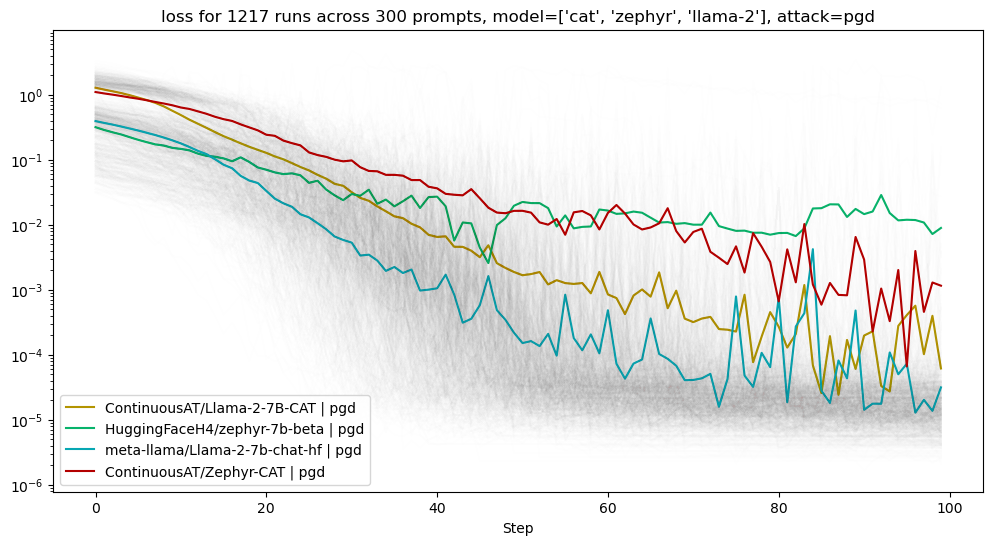

In [14]:
plot_prompts([p[0]['content'] for p in d], 'loss', model_name=['cat', 'zephyr', 'llama-2'], attack_type='pgd')

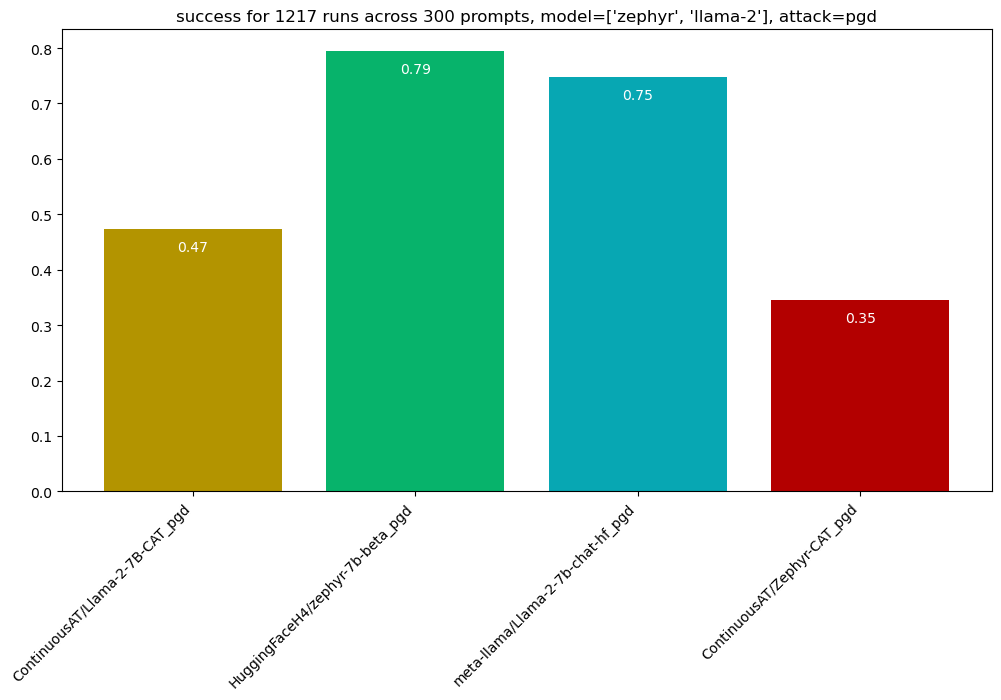

In [15]:
plot_asr([p[0]['content'] for p in d], model_name=['zephyr', 'llama-2'], attack_type='pgd')

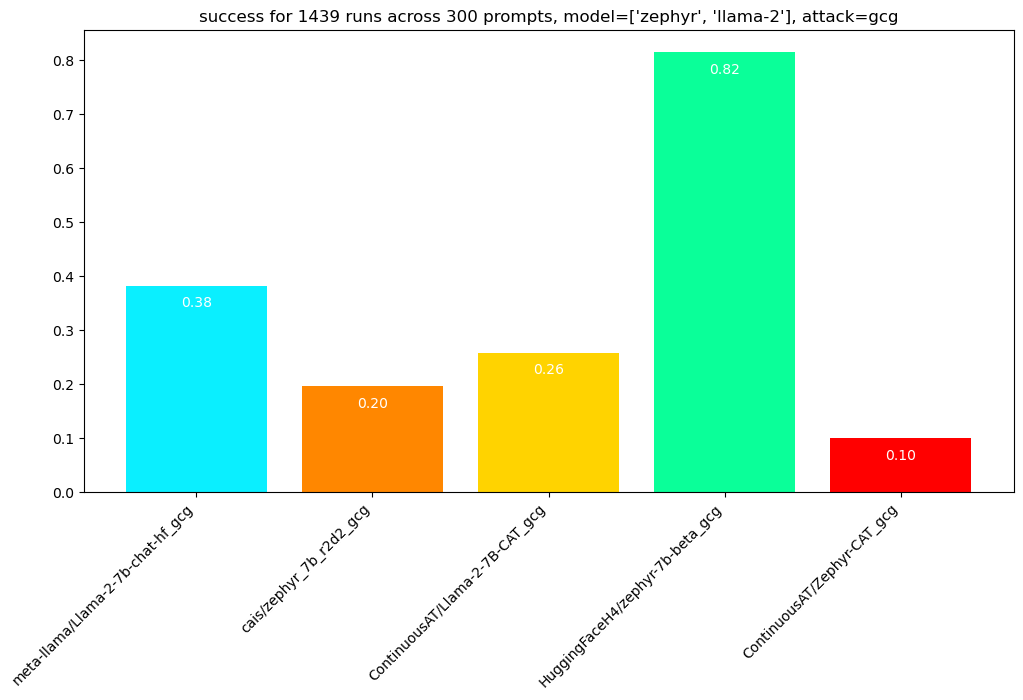

In [16]:
plot_asr([p[0]['content'] for p in d], model_name=['zephyr', 'llama-2'], attack_type='gcg')

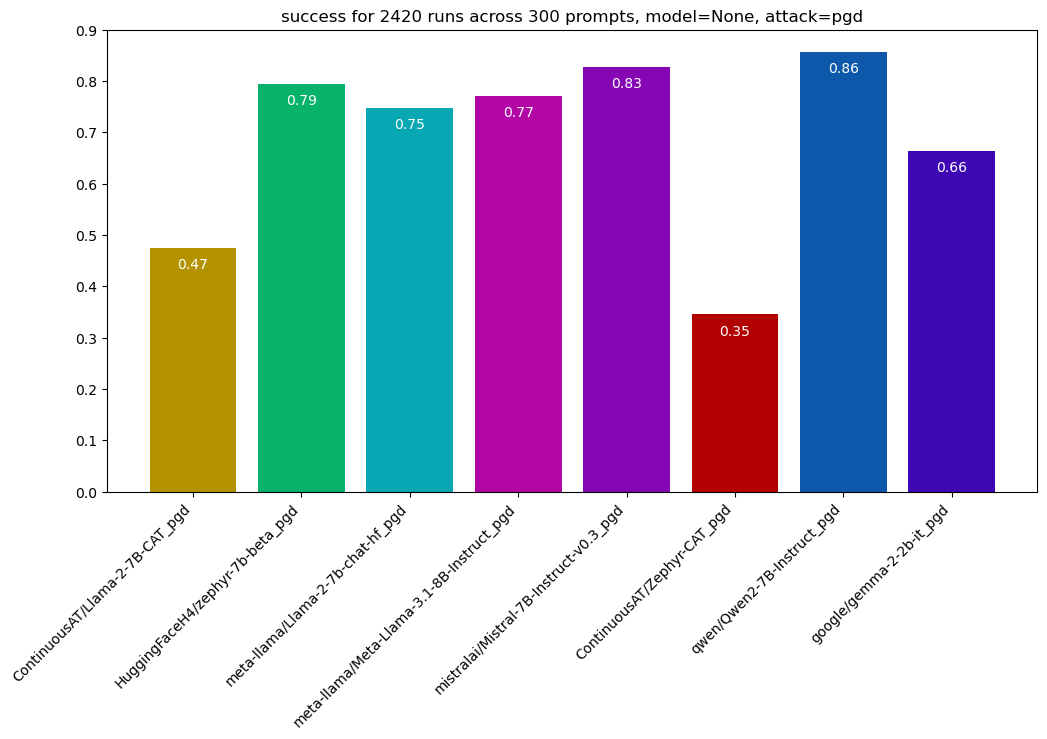

In [17]:
plot_asr([p[0]['content'] for p in d], model_name=None, attack_type='pgd')

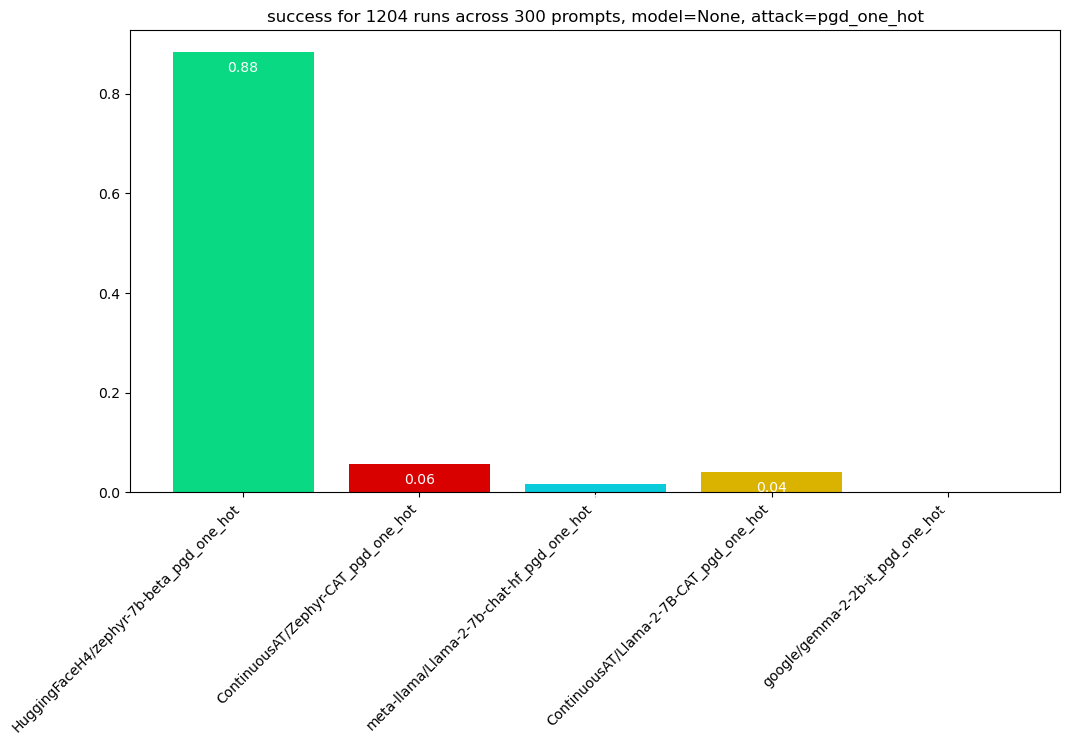

In [18]:
plot_asr([p[0]['content'] for p in d], model_name=None, attack_type='pgd_one_hot')

# Are there harder prompts?

In [19]:
def plot_avg_per_prompt(prompts, metric='loss', model_name: None|str|list[str] = None, attack_type: None|str|list[str] = None):
    if not isinstance(prompts, list):
        prompts = [prompts]
    to_plot = {}
    for prompt in prompts:
        prompt_runs = filter_runs(indexed_attack_runs[prompt], model_name, attack_type)
        to_plot[prompt] = [{'key': (run['config']['model'], run['config']['attack']), 'value': np.min(run[metric])} for run in prompt_runs]

    prompt_to_idx = {i: p[0]['content'] for i, p in enumerate(d)}
    data = [to_plot[prompt_to_idx[i]] for i in range(len(d)) if prompt_to_idx[i] in to_plot]
    labels = np.arange(len(data))#[f"{prompt_to_idx[i][:20].strip('\n')}..." for i in range(len(d))]

    plt.figure(figsize=(12, 6))

    if metric == 'loss':
        plt.violinplot([[d_['value'] for d_ in prompt_data] for prompt_data in data])
        plt.yscale('log')
        # Plot scatter points on top of the violins
        for i, prompt_data in enumerate(data):
            c = [get_color_for_run(*d_['key']) for d_ in prompt_data]
            plt.scatter([i + 1] * len(prompt_data), [d__['value'] for d__ in prompt_data], alpha=0.1, c=c)
    elif metric == 'success':
        plt.scatter(np.arange(1, len(data) + 1), [np.mean([d_['value'] for d_ in prompt_data]) for prompt_data in data])

    plt.xticks(ticks=np.arange(1, len(labels) + 1, step=10), labels=labels[::10], rotation=90)
    plt.ylabel(metric)
    plt.title(f"Average {metric} for {len(prompts)} prompts, model={model_name if model_name is not None else "All"}, attack={attack_type}")
    plt.xlabel("Prompt index")
    plt.legend()

/tmp/ipykernel_313806/3650824245.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


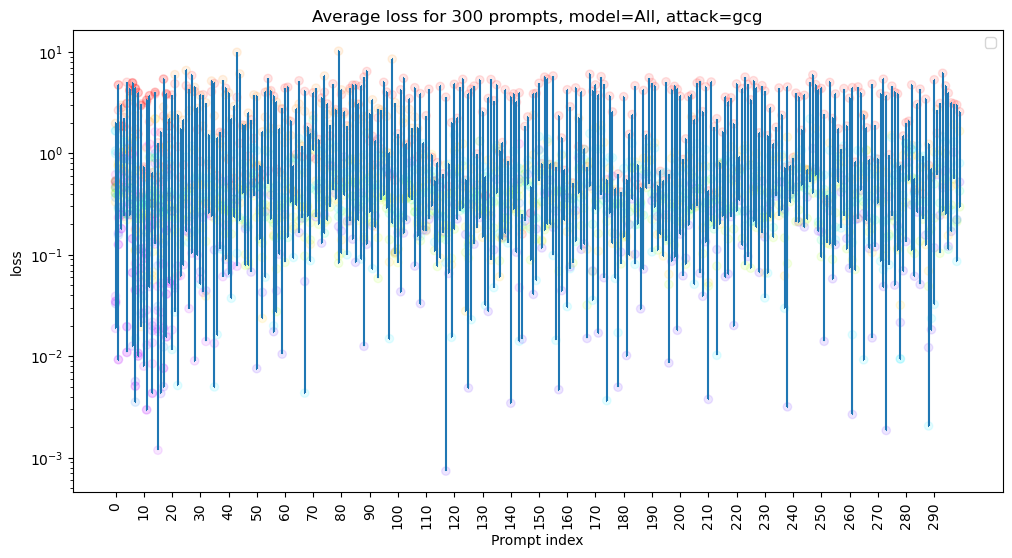

In [20]:
plot_avg_per_prompt([p[0]['content'] for p in d], 'loss', model_name=None, attack_type='gcg')

/tmp/ipykernel_313806/3650824245.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


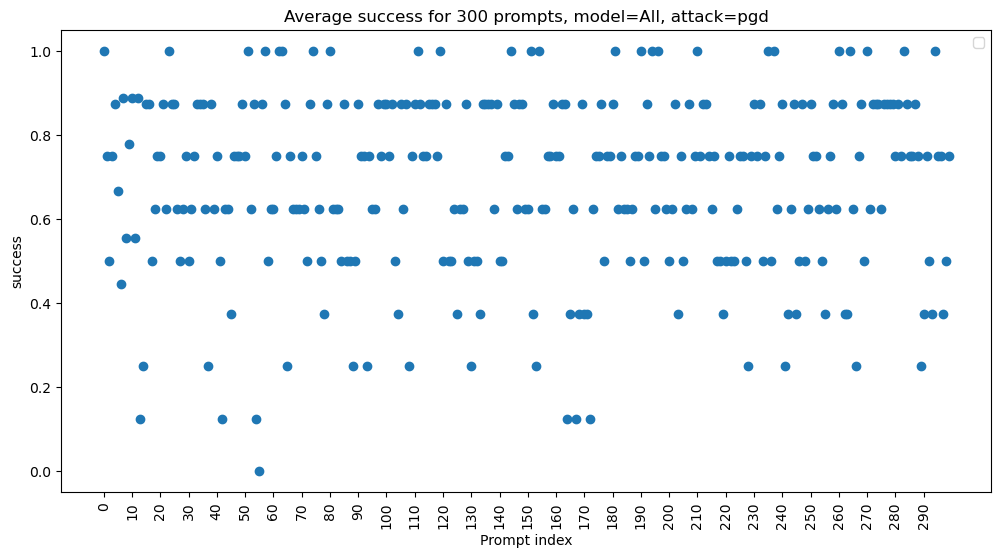

In [21]:
plot_avg_per_prompt([p[0]['content'] for p in d], 'success', model_name=None, attack_type='pgd')